In [1]:
import MegaScreen as M
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.offsetbox
from matplotlib.lines import Line2D 
import matplotlib.image
from PIL import Image
import numpy as np
import skimage
from skimage import measure
from scipy import ndimage
from scipy import signal
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import imageio
from scipy.signal import find_peaks, peak_widths
import os
import shutil
import glob
import pandas as pd
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

# Index

1. Functions

2. Input image

3. Telescope aperture and Fried parameter

4. Diffraction limitted PSF

5. Phase Screens 

6. Atmosphere PSF

7. Pupil and psf plane dimensions

8. Padding psf

9. Resampling padded psf

10. Comparing normal PSF and resampled PSF

11. Convolution of the psf with the input image

12. Comparing convolution normal psf and resampled psf

13. Crop convolution image

14. Zoom to compare resolutio

15. Multiple images convolution

16. Saving convolved images

# 1. Functions

In [2]:
def Circ_Aperture_Mask(propagator_size):

    x = np.arange(0, propagator_size)
    y = np.arange(0, propagator_size)
    arr = np.zeros((y.size, x.size))
    diam = propagator_size
    r= diam/2

    mask = (x[np.newaxis,:]-propagator_size/2)**2 + (y[:,np.newaxis]-propagator_size/2)**2 < r**2
    arr[mask] = 1.

    return arr

def quick_complex_pupil(phaseScreen, array_to_propgate_size):

    propagator_size = len(phaseScreen) 
    telescope_wavefront = np.exp(1j*phaseScreen)
    initial_pupil = Circ_Aperture_Mask(propagator_size)*telescope_wavefront 
    
    #DM padding 
    pad_left, pad_right = int(np.floor(array_to_propgate_size/2 - initial_pupil.shape[1]/2)), int(np.ceil(array_to_propgate_size/2 - initial_pupil.shape[1]/2))
    pad_up, pad_down = int(np.floor(array_to_propgate_size/2 - initial_pupil.shape[0]/2)), int(np.ceil(array_to_propgate_size/2 - initial_pupil.shape[0]/2))

    thisPupil = np.pad(initial_pupil, pad_width=((pad_left,pad_right),(pad_up, pad_down)), mode='constant')

    return  thisPupil

def quick_complex_pupil_noAtm(array_to_propgate_size):

    propagator_size = len(im_array) 
    telescope_wavefront = np.exp(1j*2*np.pi)
    initial_pupil = Circ_Aperture_Mask(propagator_size)*telescope_wavefront 
    
    #DM padding 
    pad_left, pad_right = int(np.floor(array_to_propgate_size/2 - initial_pupil.shape[1]/2)), int(np.ceil(array_to_propgate_size/2 - initial_pupil.shape[1]/2))
    pad_up, pad_down = int(np.floor(array_to_propgate_size/2 - initial_pupil.shape[0]/2)), int(np.ceil(array_to_propgate_size/2 - initial_pupil.shape[0]/2))

    thisPupil_noAtm = np.pad(initial_pupil, pad_width=((pad_left,pad_right),(pad_up, pad_down)), mode='constant')

    return  thisPupil_noAtm

def Focus_beam(Collimated_Pupil, pad_width):
    """
    Takes the collimated pupil and transforms it to a psf via a Fourier transform 
    """

    Collimated_Pupil_padded = np.pad(Collimated_Pupil,pad_width=int(pad_width),mode='constant') 

    f = np.fft.fft2(Collimated_Pupil_padded) #must be complex amplitude going in here
    fshift = np.fft.fftshift(f)
    intensity_image = (np.abs(fshift))**2
    
    return intensity_image

def angular_to_physical_pixels(angular_pixel_size, focal_length): 
    """
    Takes an angular pixel size in arcseconds/pixel ("/pixel) and converts it to meters/pixel
    or whatever the units of focal length is. 
    """
    plate_scale = 206265/focal_length
    pixel_size_input_image = angular_pixel_size*(1/plate_scale)

    return pixel_size_input_image

# 2. Input image 

In [3]:
sunspot_date = '20121117_010000'

Sub_Polarized_folder = '/home/miguel/Solar-physics-project/Thesis/atm_simulations/polarized_images/polarized_images_'+sunspot_date+'/'
Sub_Polarized_Images = sorted(glob.glob(Sub_Polarized_folder+'*.txt'))
print(Sub_Polarized_Images[0][:])

/home/miguel/Solar-physics-project/Thesis/atm_simulations/polarized_images/polarized_images_20121117_010000/20121117_010000_I0_means_0_0.txt


columns:  200
rows:  199
angular pixel size input image:  0.504283 [arcsec]
More columns than rows, crop columns
(199, 199)


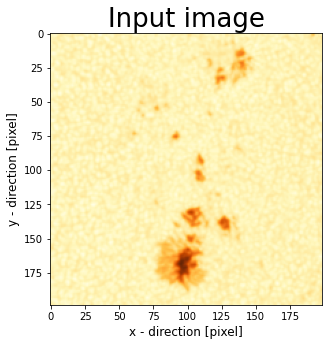

(199, 199)


In [4]:
data = pd.read_csv(Sub_Polarized_Images[0],header=None)
im_array = np.asarray(data)
im_array = np.transpose(im_array)
#im_array = im_array[1:,:]
print('columns: ',im_array.shape[1])
print('rows: ',im_array.shape[0])

hdul = fits.open('/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Hazel practice/organized/SubmapsStokes/submap.S_720s.20111027_180000_TAI.1.I0.fits')
angular_pixel_size_input_image = hdul[0].header['CDELT1']
print('angular pixel size input image: ',angular_pixel_size_input_image,'[arcsec]')

#Make array square by cropping
if (im_array.shape[0] > im_array.shape[1]):
    print('More rows than columns, crop rows')
    dfe = im_array.shape[0] - im_array.shape[1]
    im_array = im_array[dfe:]
    print(im_array.shape)
    
elif(im_array.shape[0] < im_array.shape[1]):
    print('More columns than rows, crop columns')
    dfe = im_array.shape[1] - im_array.shape[0]
    im_array = im_array[:,dfe:]
    print(im_array.shape)
else: 
    print('number of rows is equal to number of colums')
    print(im_array.shape)

    
plt.figure(figsize=(5,5))
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel('x - direction [pixel]',fontsize=12)
plt.ylabel('y - direction [pixel]',fontsize=12)
plt.imshow(im_array)
plt.title('Input image',fontsize=26)
plt.set_cmap('YlOrBr_r')
plt.show()
print(im_array.shape)

# 3. Telescope aperture and Fried parameter

In [5]:
#SDO Telescope characteristics
telescope_diameter_m = 0.14 #[ meters ]
telescope_focal_length_m = 4.95
r0_cm = 1.5

In [6]:
# Define fixe size for pixels per ro
#pixels_per_ro = 30
#telescope_aperture_width_pixels = int(np.ceil((pixels_per_ro/(r0_cm*0.01))*telescope_diameter_m))
#ro = telescope_aperture_width_pixels/(telescope_diameter_m/(r0_cm*0.01))

#print('Telescope diameter with fixed pixels per ro: ',telescope_aperture_width_pixels,' [pixels]')

Telescope diameter [m]:  0.14
Telescope diameter [cm]:  14.0
Fried parameter [cm]:  1.5
D_ro =  9.33
Telescope aperture in piexels:  199
Fried parameter in pixels:  21.32


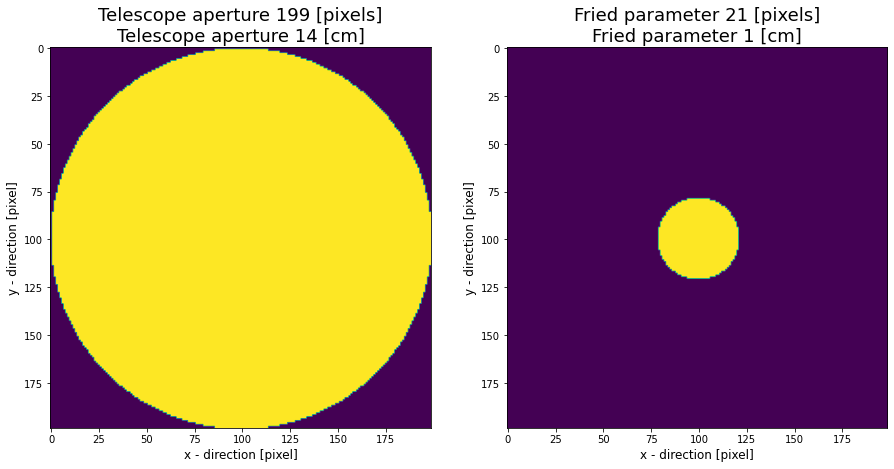

In [7]:
telescope_aperture_width_pixels = im_array.shape[1]


ro = telescope_aperture_width_pixels/(telescope_diameter_m/(r0_cm*0.01))
D_r0 = telescope_diameter_m/(r0_cm*0.01) #x adimensional value of the notes ([m]/[cm*0.01 = m])


print('Telescope diameter [m]: ',telescope_diameter_m)
print('Telescope diameter [cm]: ',round(telescope_diameter_m*1e2,2))
print('Fried parameter [cm]: ',r0_cm)
#pixels_per_ro = 30

print('D_ro = ',round(D_r0,2))

#telescope_aperture_width_pixels = int(np.ceil((pixels_per_ro/(r0_cm*0.01))*telescope_diameter_m))
#telescope_aperture_width_pixels = int(D_r0*r0)
telescope_aperture_width_pixels = len(im_array[0])
#telescope_aperture_width_pixels = 20


print('Telescope aperture in piexels: ',telescope_aperture_width_pixels)

print('Fried parameter in pixels: ',round(ro,2))


pupil = Circ_Aperture_Mask(telescope_aperture_width_pixels)

x = np.arange(0, telescope_aperture_width_pixels)
y = np.arange(0, telescope_aperture_width_pixels)
arr = np.zeros((y.size, x.size))
diam = ro*2
r= diam/2

mask = (x[np.newaxis,:]-telescope_aperture_width_pixels/2)**2 + (y[:,np.newaxis]-telescope_aperture_width_pixels/2)**2 < r**2.
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,15))
plt.set_cmap('viridis')
ax[0].imshow(pupil)
ax[0].set_title('Telescope aperture '+str(telescope_aperture_width_pixels) 
                + ' [pixels]\n'+'Telescope aperture '+str(int(telescope_diameter_m*100))+' [cm]',fontsize=18)
ax[0].set_xlabel('x - direction [pixel]',fontsize=12)
ax[0].set_ylabel('y - direction [pixel]',fontsize=12)
ax[0].tick_params(axis='x', labelsize=10)
ax[0].tick_params(axis='y', labelsize=10)

ax[1].imshow(mask)
ax[1].set_title('Fried parameter '+str(int(ro))+ 
                ' [pixels]\n'+'Fried parameter '+str(int(r0_cm))+' [cm]',fontsize=18)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_xlabel('x - direction [pixel]',fontsize=12)
ax[1].set_ylabel('y - direction [pixel]',fontsize=12)
ax[1].tick_params(axis='x', labelsize=10)
ax[1].tick_params(axis='y', labelsize=10)

#The telescope aperture is sampled according to the fried parameter pr0 or ro sampling

# 4. Diffraction limitted PSF

(199, 199)
199


Text(0.5, 1.0, 'Zoom into the PSF')

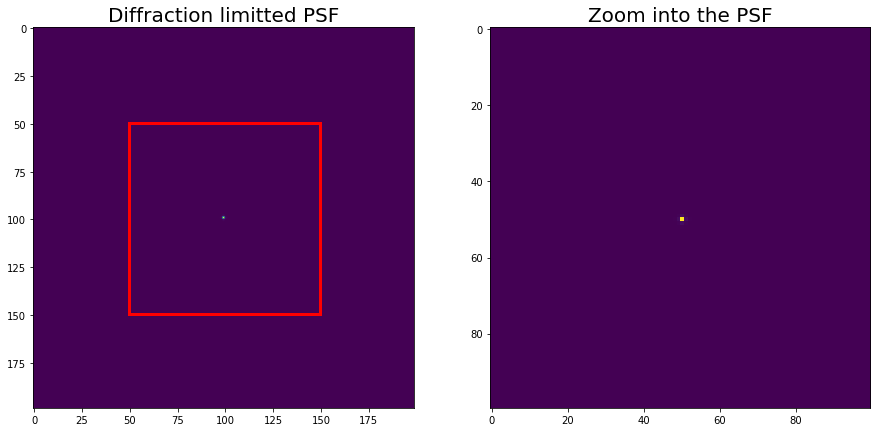

In [8]:
complex_amplitude_noAtm = quick_complex_pupil_noAtm(array_to_propgate_size=len(im_array[0]))
intensity_image_noAtm = Focus_beam(complex_amplitude_noAtm,0) #2en para buenas transformadas

image_plane_noAtm_psfs = []
image_plane_noAtm_psfs.append(intensity_image_noAtm)

psf_array_noAtm = np.asarray(intensity_image_noAtm)
print(psf_array_noAtm.shape)
im_array_size_noAtm = int(len(psf_array_noAtm))
print(im_array_size_noAtm)

sq_lenght_noAtm = 100
x_noAtm = im_array_size_noAtm/2 - sq_lenght_noAtm/2
y_noAtm = x_noAtm

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
plt.set_cmap('viridis')
ax[0].imshow(psf_array_noAtm)
ax[0].set_title('Diffraction limitted PSF',fontsize=20)
#ax[0].set_title('PSF diffraction limited only',fontsize=30)
rect = patches.Rectangle((x_noAtm,y_noAtm), sq_lenght_noAtm, sq_lenght_noAtm, linewidth=3, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[1].imshow(psf_array_noAtm[int(y_noAtm):int(y_noAtm)+sq_lenght_noAtm,int(x_noAtm):int(x_noAtm)+sq_lenght_noAtm])
ax[1].set_title('Zoom into the PSF',fontsize=20)

# 5. Phase Screens

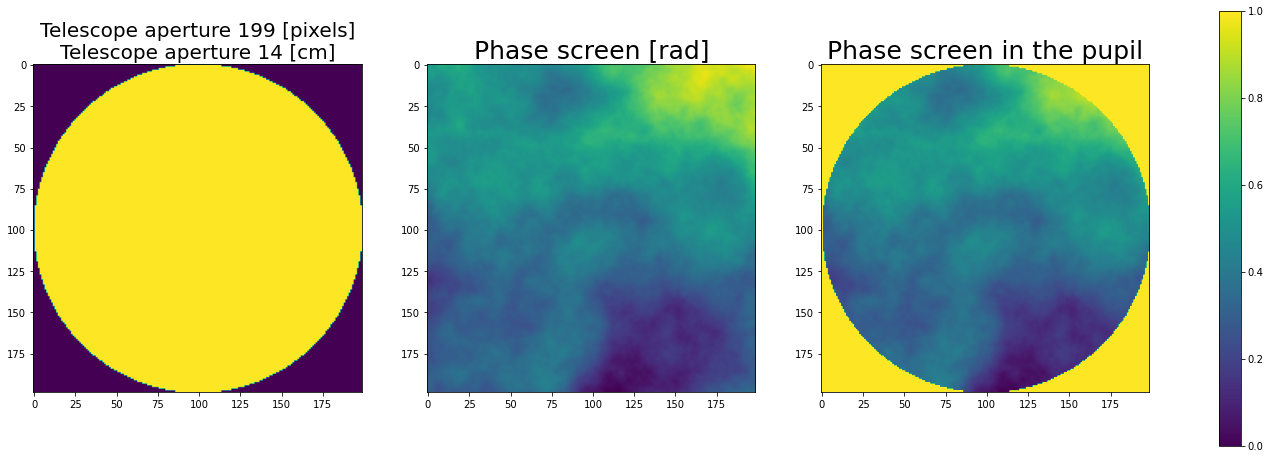

In [9]:
#maximun windowShape is (257,257)
phase_screens=[]
for phaseScreen in M.MegaScreen(r0=ro,numIter=1,dx=0.5*telescope_aperture_width_pixels,windowShape=(im_array.shape[0],telescope_aperture_width_pixels),pixelSize=1): #apparent maximum for windows shape (257.257)
    phase_screens.append(phaseScreen)
    #phase_screens.append(np.zeros((telescope_aperture_width_pixels, telescope_aperture_width_pixels),dtype=np.complex64))

    
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(25,8))
p = ax[0].imshow(pupil)
ax[0].set_title('Telescope aperture '+str(telescope_aperture_width_pixels) 
                + ' [pixels]\n'+'Telescope aperture '+str(int(telescope_diameter_m*100))+' [cm]',fontsize=20)
#ax[1].imshow(mask*2*np.pi)
ax[1].imshow(phase_screens[0])
ax[1].set_title('Phase screen [rad]',fontsize=25)
ax[2].imshow(pupil*phase_screens[0],vmin=np.min(phase_screens[0]),vmax=np.max(phase_screens[0]))
ax[2].set_title('Phase screen in the pupil',fontsize=25)
fig.colorbar(p,ax=ax)

# 6. Atmosphere PSF

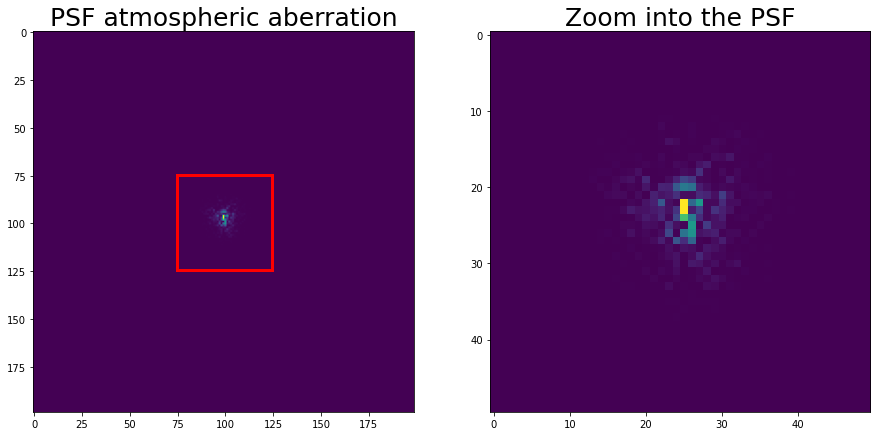

In [10]:
complex_amplitude = quick_complex_pupil(phase_screens[0], array_to_propgate_size=len(im_array[0]))
#complex_amplitude = pupil*complexphase (circ_complex pupil)

intensity_image = Focus_beam(complex_amplitude,0)
#FFT of the cric_complex pupil to generate the psf
image_plane_psfs = []
image_plane_psfs.append(intensity_image)

psf_array = np.asarray(intensity_image)
im_array_size = int(len(psf_array))

sq_lenght = 50
x = im_array_size/2 - sq_lenght/2
y = x

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
plt.set_cmap('viridis')
ax[0].imshow(psf_array)
ax[0].set_title('PSF atmospheric aberration',fontsize=25)
#ax[0].set_title('PSF diffraction limited only',fontsize=30)
rect = patches.Rectangle((x,y), sq_lenght, sq_lenght, linewidth=3, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[1].imshow(psf_array[int(y):int(y)+sq_lenght,int(x):int(x)+sq_lenght])
ax[1].set_title('Zoom into the PSF',fontsize=25)

plt.show()


# 7. Pupil and psf plane dimensions

Pixel size input image 1.2101911860955569e-05 m =  0.012101911860955569 mm
Pixel size pupil plane or aperture 0.0007035175879396985 m =  0.7035175879396985 mm

Wavelength 6.173e-07 m

pixel size psf image plane 2.182596428571428e-05 m =  0.021825964285714282 mm
pixel size psf image plane 45816.99057642684 1/m


Text(0.5, 1.0, 'Pixel size PSF plane 2.18e-05 [m]\nPixel size PSF plane 0.0218[mm]\nPixel size PSF plane 45816.99 [1/m]')

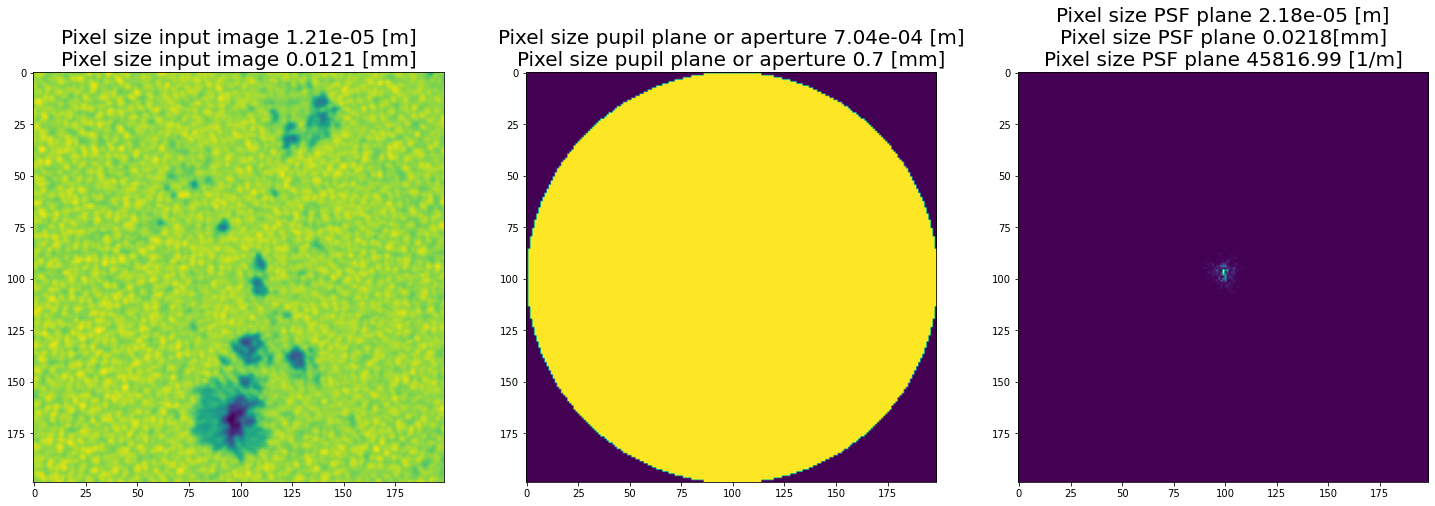

In [11]:
#using the plate scale, calculate the pixel size in meters and milimiters
pixel_size_input_image = angular_to_physical_pixels(angular_pixel_size_input_image,telescope_focal_length_m)
print('Pixel size input image',pixel_size_input_image,'m = ',pixel_size_input_image*1e3,'mm')
#Aperture or pupil plane pixel size in meters and milimeters
Pixel_size_pupil_plane = telescope_diameter_m/telescope_aperture_width_pixels
print('Pixel size pupil plane or aperture',Pixel_size_pupil_plane,'m = ',Pixel_size_pupil_plane*1e3,'mm')

print('')
wavelength = 6.173e-7
print('Wavelength',wavelength,'m')
print('')
pixel_size_psf_image_plane = (wavelength*telescope_focal_length_m)/(len(im_array)*Pixel_size_pupil_plane)
print('pixel size psf image plane',pixel_size_psf_image_plane,'m = ',pixel_size_psf_image_plane*1e3,'mm')
print('pixel size psf image plane',1/pixel_size_psf_image_plane,'1/m')

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(25,8))
ax[0].imshow(im_array)
ax[0].set_title('Pixel size input image '+"{:.2e}".format(pixel_size_input_image)+' [m]\n'
                'Pixel size input image '+str(round(pixel_size_input_image*1e3,4))+' [mm]',fontsize=20) # "{:.2e}".format(12300000)

ax[1].imshow(pupil)
ax[1].set_title('Pixel size pupil plane or aperture '+"{:.2e}".format(Pixel_size_pupil_plane)+' [m]\n'
                'Pixel size pupil plane or aperture '+str(round(Pixel_size_pupil_plane,4)*1e3)+' [mm]' ,fontsize=20)

ax[2].imshow(psf_array)
ax[2].set_title('Pixel size PSF plane '+"{:.2e}".format(pixel_size_psf_image_plane)+' [m]\n'
                'Pixel size PSF plane '+str(round(pixel_size_psf_image_plane*1e3,4))+ '[mm]\n'
                'Pixel size PSF plane '+str(round(1/pixel_size_psf_image_plane,2))+ ' [1/m]',fontsize=20)

# 8. Padding psf

(1199, 1199)
1199


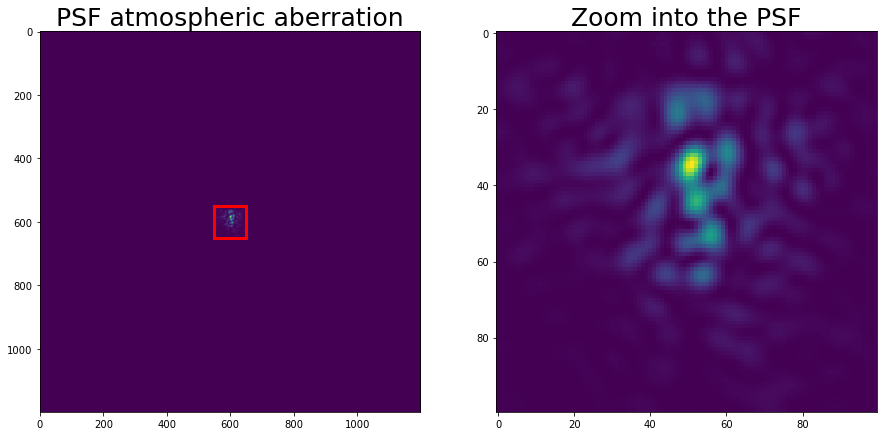

New psf pixel size:  1199
new pixel size psf image plane 3.6224911533420705e-06 m
new pixel size psf image plane 276053.1241263104 1/m


In [12]:
padding = 500

complex_amplitude_pd = quick_complex_pupil(phase_screens[0], array_to_propgate_size=len(im_array[0]))

intensity_image_pd = Focus_beam(complex_amplitude,padding)

image_plane_psfs_pd = []
image_plane_psfs_pd.append(intensity_image_pd)

psf_array_pd = np.asarray(intensity_image_pd)
print(psf_array_pd.shape)
im_array_size_pd = int(len(psf_array_pd))
print(im_array_size_pd)

sq_lenght_pd = 100
x_pd = im_array_size_pd/2 - sq_lenght_pd/2
y_pd = x_pd

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
plt.set_cmap('viridis')
ax[0].imshow(psf_array_pd)
ax[0].set_title('PSF atmospheric aberration',fontsize=25)
#ax[0].set_title('PSF diffraction limited only',fontsize=30)
rect_pd = patches.Rectangle((x_pd,y_pd), sq_lenght_pd, sq_lenght_pd, linewidth=3, edgecolor='r', facecolor='none')
ax[0].add_patch(rect_pd)
ax[1].imshow(psf_array_pd[int(y_pd):int(y_pd)+sq_lenght_pd,int(x_pd):int(x_pd)+sq_lenght_pd])
ax[1].set_title('Zoom into the PSF',fontsize=25)

plt.show()

print('New psf pixel size: ',len(psf_array_pd))
pixel_size_psf_image_plane_pd = (wavelength*telescope_focal_length_m)/(len(psf_array_pd)*Pixel_size_pupil_plane)
print('new pixel size psf image plane',pixel_size_psf_image_plane_pd,'m')
print('new pixel size psf image plane',1/pixel_size_psf_image_plane_pd,'1/m')

# 9. Resampling padded psf

padded psf size:  (1199, 1199)
resamppled padded psf  (199, 199)
199


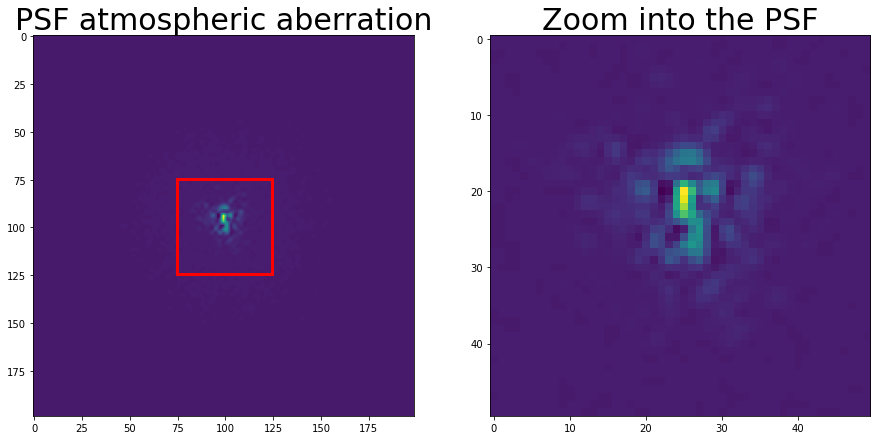

New psf pixel size:  199
new pixel size psf image plane 2.182596428571428e-05 m
new pixel size psf image plane 45816.99057642684 1/m


In [13]:
pixel_size_psf_image_plane = pixel_size_psf_image_plane

x_psf_samples = np.linspace(-pixel_size_psf_image_plane*len(image_plane_psfs[0])/2, pixel_size_psf_image_plane*len(image_plane_psfs[0])/2, len(image_plane_psfs[0]))
y_psf_samples = np.linspace(-pixel_size_psf_image_plane*len(image_plane_psfs[0])/2, pixel_size_psf_image_plane*len(image_plane_psfs[0])/2, len(image_plane_psfs[0]))

f = interpolate.interp2d(x_psf_samples, y_psf_samples, image_plane_psfs[0], kind='cubic')

x_input_image = np.linspace(-pixel_size_input_image*len(im_array)/2, pixel_size_input_image*len(im_array)/2, len(im_array))
y_input_image = np.linspace(-pixel_size_input_image*len(im_array)/2, pixel_size_input_image*len(im_array)/2, len(im_array))

resampled_psf = f(x_input_image, y_input_image)
image_plane_psfs[0] = resampled_psf


print('padded psf size: ',psf_array_pd.shape)
print('resamppled padded psf ',resampled_psf.shape)

im_array_size_rsampled = int(len(resampled_psf))
print(im_array_size_rsampled)

sq_lenght_rsampled = 50
x_rsampled = im_array_size_rsampled/2 - sq_lenght_rsampled/2
y_rsampled = x_rsampled

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
plt.set_cmap('viridis')
ax[0].imshow(resampled_psf)
ax[0].set_title('PSF atmospheric aberration',fontsize=30)
#ax[0].set_title('PSF diffraction limited only',fontsize=30)
rect_rsampled = patches.Rectangle((x_rsampled,y_rsampled), sq_lenght_rsampled, sq_lenght_rsampled, linewidth=3, edgecolor='r', facecolor='none')
ax[0].add_patch(rect_rsampled)
ax[1].imshow(resampled_psf[int(y_rsampled):int(y_rsampled)+sq_lenght_rsampled,int(x_rsampled):int(x_rsampled)+sq_lenght_rsampled])
ax[1].set_title('Zoom into the PSF',fontsize=30)

plt.show()

print('New psf pixel size: ',len(resampled_psf))
pixel_size_psf_image_plane_rsampled = (wavelength*telescope_focal_length_m)/(len(resampled_psf)*Pixel_size_pupil_plane)
print('new pixel size psf image plane',pixel_size_psf_image_plane_rsampled,'m')
print('new pixel size psf image plane',1/pixel_size_psf_image_plane_rsampled,'1/m')

# 10. Comparing normal PSF and resampled PSF

Square size for zoom normal psf : 50
Square size for zoom resampled psf : 50


Text(0.5, 1.0, 'Zoom into the PSF')

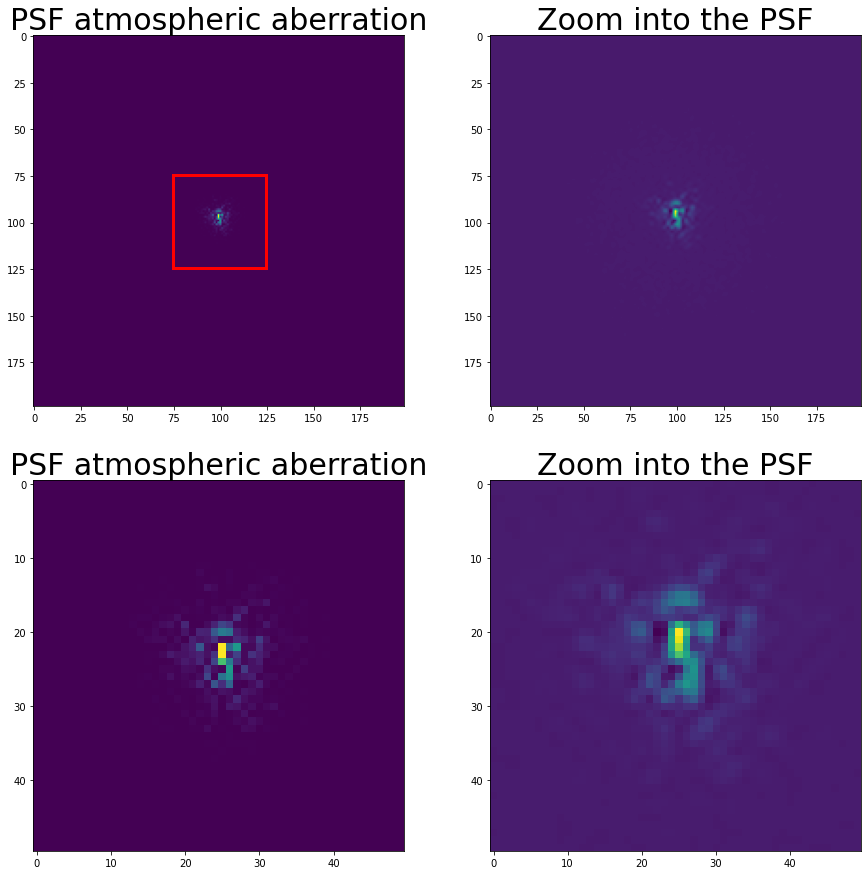

In [14]:
print('Square size for zoom normal psf :',sq_lenght)
print('Square size for zoom resampled psf :',sq_lenght_rsampled)

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
plt.set_cmap('viridis')
ax[0,0].imshow(psf_array)
ax[0,0].set_title('PSF atmospheric aberration',fontsize=30)
ax[1,0].imshow(psf_array[int(y):int(y)+sq_lenght,int(x):int(x)+sq_lenght])
ax[1,0].set_title('PSF atmospheric aberration',fontsize=30)
rect_rsampled = patches.Rectangle((x_rsampled,y_rsampled), sq_lenght_rsampled, sq_lenght_rsampled, linewidth=3, edgecolor='r', facecolor='none')
ax[0,0].add_patch(rect_rsampled)
ax[0,1].imshow(resampled_psf)
ax[0,1].set_title('Zoom into the PSF',fontsize=30)
ax[1,1].imshow(resampled_psf[int(y_rsampled):int(y_rsampled)+sq_lenght_rsampled,int(x_rsampled):int(x_rsampled)+sq_lenght_rsampled])
ax[1,1].set_title('Zoom into the PSF',fontsize=30)



# 11. Convolution of the psf with the input image

In [15]:
image_plane_psfs = []
#for i in range()
image_plane_psfs.append(intensity_image) #append: add to your array, so add intensity image to the blanc array image_plane_psf
#scipy.signal.convolve(in1, in2, mode='full', method='auto')[source]
#in1 and in2 should be the same size
print('input image size: ',im_array.shape)
print('psf size: ',np.asarray(image_plane_psfs).shape)
print('normalize psf for the convolution')

convolved_images = []
convolved_array_shape = np.shape(signal.convolve(im_array, image_plane_psfs[0]*(1/np.max(image_plane_psfs[0])),mode='same', method='auto'))
print('convolved_array_shape: ',convolved_array_shape)

convolved_array = np.zeros((convolved_array_shape[0],convolved_array_shape[1])) 
print('convolved_array_shape: ',convolved_array.shape)


temp = signal.convolve(im_array, image_plane_psfs[0]*(1/np.max(image_plane_psfs[0])),mode='same', method='auto')
convolved_array = temp

input image size:  (199, 199)
psf size:  (1, 199, 199)
normalize psf for the convolution
convolved_array_shape:  (199, 199)
convolved_array_shape:  (199, 199)


Text(0.5, 1.0, 'With atmosphere r0 = 1 cm')

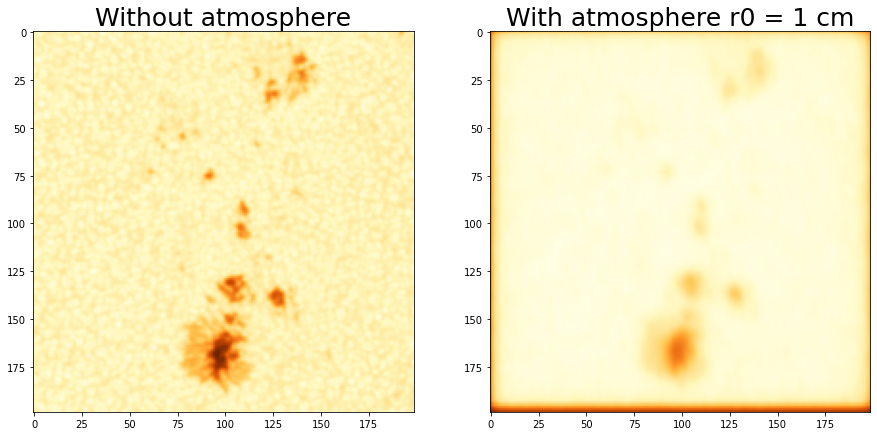

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
plt.set_cmap('YlOrBr_r')
ax[0].imshow(im_array)
ax[0].set_title('Without atmosphere',fontsize=25)
ax[1].imshow(convolved_array)
ax[1].set_title('With atmosphere r0 = %i cm'%r0_cm,fontsize=25)

# 12. Comparing convolution normal psf and resampled psf

input image size:  (199, 199)
psf size:  (199, 199)
normalize psf for the convolution
convolved_array_shape:  (199, 199)
convolved_array_shape:  (199, 199)


Text(0.5, 1.0, 'Resampled PSF convolution')

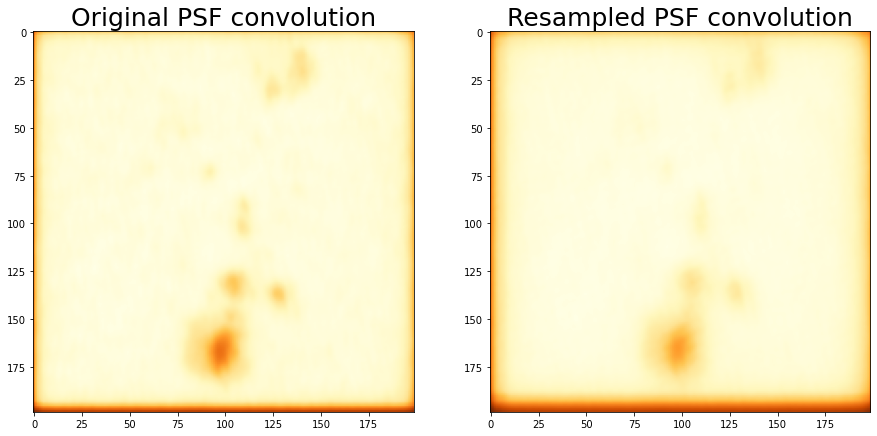

In [17]:
image_plane_psfs_rsampled = []
#for i in range()
image_plane_psfs_rsampled.append(resampled_psf) #append: add to your array, so add intensity image to the blanc array image_plane_psf
#scipy.signal.convolve(in1, in2, mode='full', method='auto')[source]
#in1 and in2 should be the same size
print('input image size: ',im_array.shape)
print('psf size: ',np.asarray(resampled_psf).shape)
print('normalize psf for the convolution')

convolved_images_rsampled = []
convolved_array_shape_rsampled = np.shape(signal.convolve(im_array, image_plane_psfs_rsampled[0]*(1/np.max(image_plane_psfs_rsampled[0]))
                                                 ,mode='same', method='auto'))
print('convolved_array_shape: ',convolved_array_shape_rsampled)

convolved_array_rsampled = np.zeros((convolved_array_shape_rsampled[0],convolved_array_shape_rsampled[1])) 
print('convolved_array_shape: ',convolved_array_rsampled.shape)


temp_rsampled = signal.convolve(im_array, image_plane_psfs_rsampled[0]*(1/np.max(image_plane_psfs_rsampled[0])),mode='same', method='auto')
convolved_array_rsampled = temp_rsampled


fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
plt.set_cmap('YlOrBr_r')
ax[0].imshow(convolved_array)
ax[0].set_title('Original PSF convolution',fontsize=25)
ax[1].imshow(convolved_array_rsampled)
ax[1].set_title('Resampled PSF convolution',fontsize=25)

# 13. Crop convolution image

Text(0.5, 1.0, 'r0 = 1 cm')

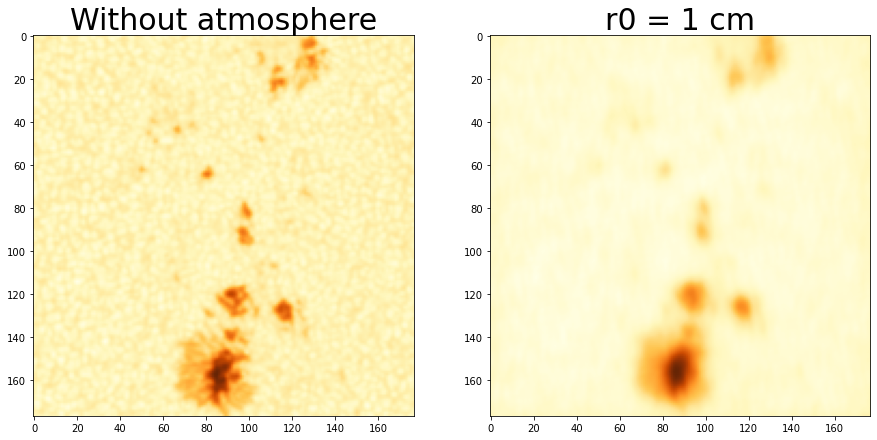

In [18]:
final_image_size = 177
x = len(convolved_array)/2 - final_image_size/2
y = x

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
plt.set_cmap('YlOrBr_r')
ax[0].imshow(im_array[int(y):int(y)+final_image_size,int(x):int(x)+final_image_size])
ax[0].set_title('Without atmosphere',fontsize=30)
ax[1].imshow(convolved_array[int(y):int(y)+final_image_size,int(x):int(x)+final_image_size])
ax[1].set_title('r0 = %i cm'%r0_cm,fontsize=30)



# 13.5 Resolution lost

# 14. Zoom to compare resolution

Text(0.5, 1.0, 'With atmosphere r0 = 1 cm')

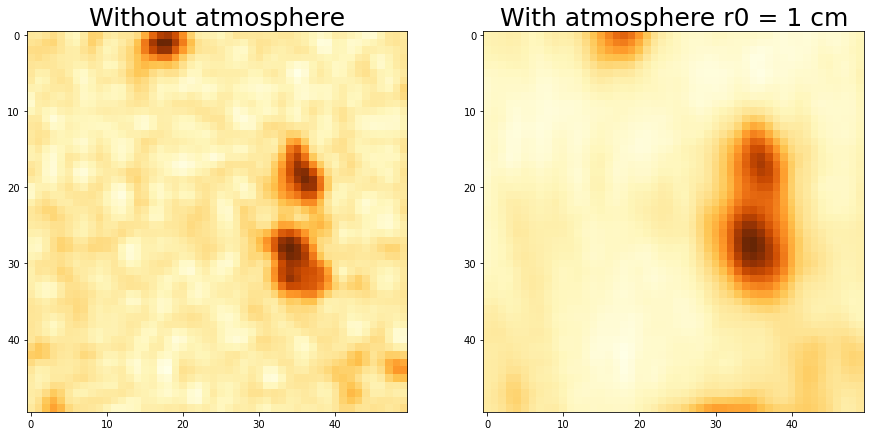

In [19]:
final_image_size_sz = 50
x_sz = len(convolved_array)/2 - final_image_size_sz/2
y_sz = x_sz

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
plt.set_cmap('YlOrBr_r')
ax[0].imshow(im_array[int(y_sz):int(y_sz)+final_image_size_sz,int(x_sz):int(x_sz)+final_image_size_sz])
ax[0].set_title('Without atmosphere',fontsize=25)
ax[1].imshow(convolved_array[int(y_sz):int(y_sz)+final_image_size_sz,int(x_sz):int(x_sz)+final_image_size_sz])
ax[1].set_title('With atmosphere r0 = %i cm'%r0_cm,fontsize=25)

# 15. Multiple images convolution

In [20]:
shape_arrays = pd.read_csv(Sub_Polarized_Images[0],header=None).iloc[:,:].shape
print(shape_arrays)

(200, 199)


In [21]:
multi_convolved_array = np.zeros((len(Sub_Polarized_Images),convolved_array_shape[0],convolved_array_shape[1]))
multi_data = multi_convolved_array
print(multi_data.shape)
mult_im_array = multi_convolved_array
multi_temp = multi_convolved_array

for i in range(len(Sub_Polarized_Images)):
    if (shape_arrays[0] > shape_arrays[1]):
        #print('crop rows')
        multi_data[i,:,:] = pd.read_csv(Sub_Polarized_Images[i],header=None).iloc[1:,:]
    elif (shape_arrays[0] < shape_arrays[1]):
        #print('crop columns')
        multi_data[i,:,:] = pd.read_csv(Sub_Polarized_Images[i],header=None).iloc[:,1:]
    else:
        multi_data[i,:,:] = pd.read_csv(Sub_Polarized_Images[i],header=None)
    mult_im_array[i,:,:] = np.asarray(multi_data[i,:,:])
    multi_temp[i,:,:] = signal.convolve(mult_im_array[i,:,:], image_plane_psfs[0]*(1/np.max(image_plane_psfs[0])),
                                 mode='same', method='auto')
    multi_convolved_array[i,:,:] = multi_temp[i,:,:]
    

(36, 199, 199)


# 16. Saving  convolved images

In [22]:
#organize name
n1 = 108
n2 = 123
print(Sub_Polarized_Images[0][n1:n2])

n11 = 108
print(Sub_Polarized_Images[0][n11:])

20121117_010000
20121117_010000_I0_means_0_0.txt


In [23]:
path_pimages = '/home/miguel/Solar-physics-project/Thesis/atm_simulations/Atm_polarized_images/'+'r0_cm'+str(r0_cm)+'_'+Sub_Polarized_Images[0][n1:n2]+'/'
if os.path.exists(path_pimages):
    shutil.rmtree(path_pimages)
os.makedirs(path_pimages)

for i in range(len(Sub_Polarized_Images)):
    fname_template = 'Atm_'+'r0_cm'+str(r0_cm)+'_'+ Sub_Polarized_Images[i][n11:]
    np.savetxt(path_pimages+fname_template.format(i=i),
               multi_convolved_array[i,int(y):int(y)+final_image_size,int(x):int(x)+final_image_size], 
               fmt='%s',delimiter=',')

In [24]:
#check size and open saved image 
Atm_Polarized_Images = sorted(glob.glob(path_pimages+'*.txt'))

data = pd.read_csv(Atm_Polarized_Images[0],header=None)
print('Atm polarized image shape: ',data.shape)
print('')
for i in range(36):
    print(Atm_Polarized_Images[i][102:])
    

Atm polarized image shape:  (177, 177)

0/Atm_r0_cm1.5_20121117_010000_I0_means_0_0.txt
0/Atm_r0_cm1.5_20121117_010000_I0_means_135_0.txt
0/Atm_r0_cm1.5_20121117_010000_I0_means_135_90.txt
0/Atm_r0_cm1.5_20121117_010000_I0_means_45_0.txt
0/Atm_r0_cm1.5_20121117_010000_I0_means_45_90.txt
0/Atm_r0_cm1.5_20121117_010000_I0_means_90_0.txt
0/Atm_r0_cm1.5_20121117_010000_I1_means_0_0.txt
0/Atm_r0_cm1.5_20121117_010000_I1_means_135_0.txt
0/Atm_r0_cm1.5_20121117_010000_I1_means_135_90.txt
0/Atm_r0_cm1.5_20121117_010000_I1_means_45_0.txt
0/Atm_r0_cm1.5_20121117_010000_I1_means_45_90.txt
0/Atm_r0_cm1.5_20121117_010000_I1_means_90_0.txt
0/Atm_r0_cm1.5_20121117_010000_I2_means_0_0.txt
0/Atm_r0_cm1.5_20121117_010000_I2_means_135_0.txt
0/Atm_r0_cm1.5_20121117_010000_I2_means_135_90.txt
0/Atm_r0_cm1.5_20121117_010000_I2_means_45_0.txt
0/Atm_r0_cm1.5_20121117_010000_I2_means_45_90.txt
0/Atm_r0_cm1.5_20121117_010000_I2_means_90_0.txt
0/Atm_r0_cm1.5_20121117_010000_I3_means_0_0.txt
0/Atm_r0_cm1.5_201211

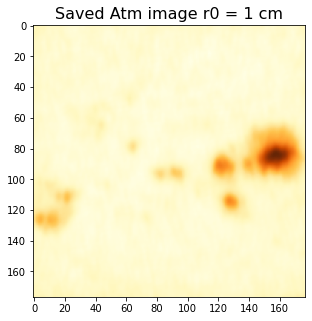

In [25]:
check_data = pd.read_csv(Atm_Polarized_Images[0],header=None)
check_array = np.asarray(check_data)
plt.figure(figsize=(5,5))
plt.title('Saved Atm image r0 = %i cm'%r0_cm,fontsize=16)
plt.imshow(check_array)

In [241]:
#%reset